In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import learning_curve
import xgboost as xgb
import joblib

In [3]:
df = pd.read_csv("synthetic_train_data.csv", parse_dates=["invoice_date", "due_date", "payment_date"])

In [5]:
df["anomaly_type"].fillna("No Anomaly", inplace=True)

In [6]:
categorical_columns = ["supplier_name", "customer_name", "category", "note", 
                       "transaction_type", "payment_status", "anomaly_type"]
df[categorical_columns] = df[categorical_columns].astype("category")

In [7]:
df["items_count"] = df["items"].apply(lambda x: len(str(x).split(';')))

In [8]:
df["avg_item_value"] = (df["total_amount"] / df["items_count"].astype(float)).round(2)

In [9]:
supplier_frequency = df["supplier_name"].value_counts()
customer_frequency = df["customer_name"].value_counts()

supplier_treshold = 3000
customer_treshold = 4500

def categorize_supplier(supplier_name):
    if supplier_name == "FinDoc AI":
        return "Special"
    elif supplier_frequency[supplier_name] > supplier_treshold:
        return "Top Supplier"
    else:
        return "Active Supplier"
    
def categorize_customer(customer_name):
    if customer_name == "FinDoc AI":
        return "Special"
    elif customer_frequency[customer_name] > customer_treshold:
        return "Top Customer"
    else:
        return "Active Customer"
    
df["supplier_category"] = df["supplier_name"].apply(categorize_supplier).astype("category")
df["customer_category"] = df["customer_name"].apply(categorize_customer).astype("category")

In [10]:
df["days_to_due"] = (df["due_date"] - df["invoice_date"]).dt.days

In [11]:
customer_avg = df.groupby("customer_name", observed=True)["total_amount"].mean()
customer_std = df.groupby("customer_name", observed=True)["total_amount"].std()

supplier_avg = df.groupby("supplier_name", observed=True)["total_amount"].mean()
supplier_std = df.groupby("supplier_name", observed=True)["total_amount"].std()

df["customer_mean"] = df["customer_name"].map(customer_avg).astype(float).round(2)
df["customer_std"] = df["customer_name"].map(customer_std).astype(float).round(2)
df["supplier_mean"] = df["supplier_name"].map(supplier_avg).astype(float).round(2)
df["supplier_std"] = df["supplier_name"].map(supplier_std).astype(float).round(2)

In [12]:
df["note"] = df["note"].str.replace("Faktura za: ", "", regex=False)

In [13]:
# Inicializace LabelEncoder
label_encoders = {}

# Kódování kategorických sloupců
categorical_columns = ["supplier_name", "customer_name", "category", "transaction_type", "note", "supplier_category", "customer_category"]

for col in categorical_columns:
    le = LabelEncoder()
    df[col + "_encoded"] = le.fit_transform(df[col])
    label_encoders[col] = le

joblib.dump(label_encoders, "label_encoders.pkl")

['label_encoders.pkl']

In [14]:
le = LabelEncoder()
# Kódování sloupce anomaly_type
df["anomaly_type_encoded"] = le.fit_transform(df["anomaly_type"])
label_encoders.update({"anomaly_type": le})

In [ ]:
# Zobrazení mapování pro konkrétní sloupec
def display_mapping(label_encoders, col_name):
    le = label_encoders[col_name]
    mapping_df = pd.DataFrame({
        "Encoded": range(len(le.classes_)),
        "Category": le.classes_
    })
    return mapping_df

display_mapping(label_encoders, "anomaly_type")

,Encoded,Category
0,0,High Value + Short Due Date
1,1,Items Total Mismatch + Unusual Due Date
2,2,No Anomaly
3,3,Unusual Number of Items
4,4,Unusual Service for Customer


In [17]:
features = ['total_amount', 'is_month_end', 'items_count', 'avg_item_value',
       'days_to_due', 'customer_mean', 'customer_std', 'supplier_mean',
       'supplier_std', 'supplier_name_encoded', 'customer_name_encoded',
       'category_encoded', 'transaction_type_encoded', "note_encoded",
       'supplier_category_encoded', 'customer_category_encoded', "anomaly_type_encoded"]

In [18]:
X = df[features].drop("anomaly_type_encoded", axis=1)
y = df[features]["anomaly_type_encoded"]

# První rozdělení na trénovací a dočasná data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Druhé rozdělení do validační a testovací sady
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.333, random_state=42, stratify=y_temp)



scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, "scaler.pkl")

X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


xgb_model = xgb.XGBClassifier(n_estimators=100,
                              random_state=42,
                              max_depth=10,
                              min_child_weight=5,
                              learning_rate=0.1,
                              subsample=0.8,
                              colsample_bytree=0.8)

xgb_model.fit(X_train_scaled, y_train)
y_val_pred_xgb = xgb_model.predict(X_val_scaled)



print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print("Validation Classification Report for XGBoost:")
print(classification_report(y_val, y_val_pred_xgb))
print("Validation Confusion Matrix for XGBoost:")
print(confusion_matrix(y_val, y_val_pred_xgb))
print("Validation Accuracy for XGBoost:", accuracy_score(y_val, y_val_pred_xgb))

Training set size: 35000
Validation set size: 10005
Test set size: 4995
Validation Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       318
           1       1.00      1.00      1.00       322
           2       1.00      1.00      1.00      9093
           3       1.00      1.00      1.00       184
           4       1.00      0.74      0.85        88

    accuracy                           1.00     10005
   macro avg       1.00      0.95      0.97     10005
weighted avg       1.00      1.00      1.00     10005

Validation Confusion Matrix for XGBoost:
[[ 318    0    0    0    0]
 [   0  322    0    0    0]
 [   0    0 9093    0    0]
 [   0    0    0  184    0]
 [   0    0   23    0   65]]
Validation Accuracy for XGBoost: 0.9977011494252873


In [19]:
# Uložení modelu
joblib.dump(xgb_model, "xgb_model.pkl")

['xgb_model.pkl']

In [20]:
# načtení modelu xgb_model
loaded_model = joblib.load("xgb_model.pkl")

# Test modelu na X_test_scaled
y_test_pred_xgb = loaded_model.predict(X_test_scaled)
print("Test Classification Report for XGBoost:")
print(classification_report(y_test, y_test_pred_xgb))
print("Test Confusion Matrix for XGBoost:")
print(confusion_matrix(y_test, y_test_pred_xgb))
print("Test Accuracy for XGBoost:", accuracy_score(y_test, y_test_pred_xgb))


Test Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       159
           1       1.00      1.00      1.00       161
           2       1.00      1.00      1.00      4540
           3       1.00      1.00      1.00        91
           4       1.00      0.75      0.86        44

    accuracy                           1.00      4995
   macro avg       1.00      0.95      0.97      4995
weighted avg       1.00      1.00      1.00      4995

Test Confusion Matrix for XGBoost:
[[ 159    0    0    0    0]
 [   0  161    0    0    0]
 [   0    0 4540    0    0]
 [   0    0    0   91    0]
 [   0    0   11    0   33]]
Test Accuracy for XGBoost: 0.9977977977977978


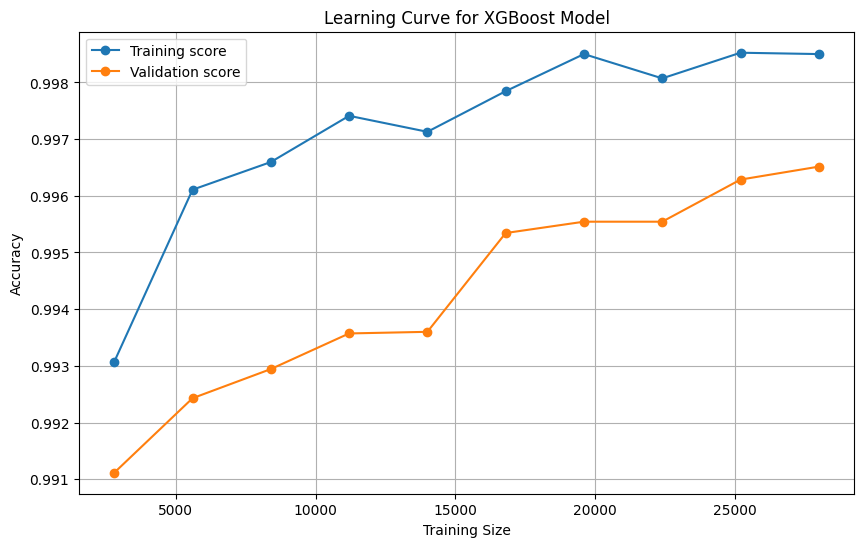

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    xgb_model, X_train_scaled, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='accuracy', n_jobs=-1
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Validation score', marker='o')
plt.title('Learning Curve for XGBoost Model')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

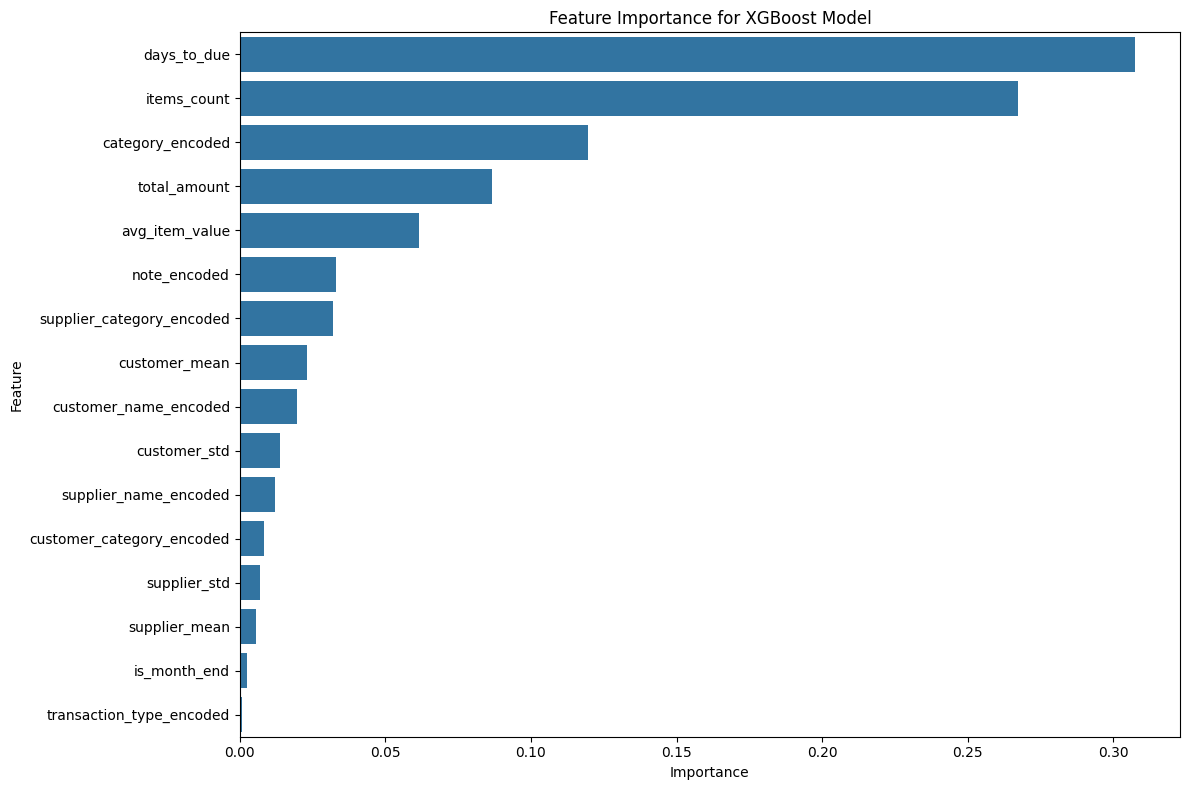

In [ ]:
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': loaded_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()